In [239]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate

In [240]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
display(train_data.shape)
display(test_data.shape)
dfs = [train_data, test_data]

(8693, 14)

(4277, 13)

In [241]:
def summary(df):
    print(f"dataset has {df.shape[1]} and {df.shape[0]} examples")
    summary = pd.DataFrame(index=df.columns)
    summary['Missing'] = df.isna().sum().values
    summary['Unique_values'] = df.nunique().values
    summary['Duplicated'] = df.duplicated().sum()
    summary['Types'] = df.dtypes
    
    return summary

In [242]:
for df in dfs:
    passengerId_split = df.PassengerId.str.split('_')
    # type(passengerId_split)
    df['group_id'] = passengerId_split.str[0]
    df['group_id'] = df['group_id'].astype(int)

In [243]:
summary(df)

dataset has 14 and 4277 examples


,Missing,Unique_values,Duplicated,Types
PassengerId,0,4277,0,object
HomePlanet,87,3,0,object
CryoSleep,93,2,0,object
Cabin,100,3265,0,object
Destination,92,3,0,object
Age,91,79,0,float64
VIP,93,2,0,object
RoomService,82,842,0,float64
FoodCourt,106,902,0,float64
ShoppingMall,98,715,0,float64


In [244]:
summary(test_data)

dataset has 14 and 4277 examples


,Missing,Unique_values,Duplicated,Types
PassengerId,0,4277,0,object
HomePlanet,87,3,0,object
CryoSleep,93,2,0,object
Cabin,100,3265,0,object
Destination,92,3,0,object
Age,91,79,0,float64
VIP,93,2,0,object
RoomService,82,842,0,float64
FoodCourt,106,902,0,float64
ShoppingMall,98,715,0,float64


In [245]:
for df in dfs:
    tmp_df = df[df['HomePlanet'].notna()]
    tmp_df = tmp_df.groupby('group_id').apply(lambda x: x['HomePlanet'].unique()[0])
    df['HomePlanet'] = df.apply(
        lambda row: ((tmp_df[row['group_id']] if row['group_id'] in tmp_df.index else np.NaN) 
                    if pd.isnull(row['HomePlanet']) else row['HomePlanet']), axis = 1
    )

In [246]:
for df in dfs:
    tmp = df['HomePlanet'].value_counts()
    v = tmp.index # ['Earth', 'Europa', 'Mars']
    p = tmp.values 
    p = p/sum(p)
    df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = np.random.choice(v, df['HomePlanet'].isna().sum(), p=p)
    df['HomePlanet'] = df['HomePlanet'].astype('category')

In [247]:
for df in dfs:
    df['total_spend'] = df['RoomService'] + df['FoodCourt'] + \
                                df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    df['any_spend'] = np.where(df['total_spend'] > 0, True, False)
    spend_criteria = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [248]:
for df in dfs:
    df['CryoSleep'] = df['CryoSleep'].astype(bool)
    df.loc[df['CryoSleep'] == True][spend_criteria].isna().sum()

In [249]:
for df in dfs:
    for criteria in spend_criteria:
        df.loc[df['CryoSleep'] == True & df[criteria].isna(), criteria] = 0

In [250]:
for df in dfs:
    df.loc[df['any_spend'] == True & df['CryoSleep'].isna(), 'CryoSleep'] = False
    df['CryoSleep'] = df['CryoSleep'].astype(int)
    df['CryoSleep'].isna().sum()

In [251]:
for df in dfs:
    df.loc[df['CryoSleep'] == 1 & df['total_spend'].isna(), 'total_spend'] = 0
    df['total_spend'].isna().sum()

In [252]:
for df in dfs:
    tmp_df = df[df['Cabin'].notna()]
    tmp_df = tmp_df.groupby('group_id').apply(lambda x: x['Cabin'].unique()[0])
    df['Cabin'] = df.apply(
        lambda row: ((tmp_df[row['group_id']] if row['group_id'] in tmp_df.index else np.NaN) 
                    if pd.isnull(row['Cabin']) else row['Cabin']), axis = 1
    )

In [253]:
for df in dfs:
    tmp = df['Cabin'].apply(lambda x: x.split('/') if type(x) != float else ['-1', '-1', '-1']).to_list()
    tmp = np.array(tmp)
    df['cabin_deck'] = tmp[:, 0]
    df['cabin_num'] = tmp[:, 1]
    df['cabin_side'] = tmp[:, 2]
    df.drop(columns = 'Cabin', inplace = True)

In [254]:
for df in dfs:
    df.loc[df['cabin_deck']=='-1', 'cabin_deck'] = np.random.choice(['F', 'G'], 
                                                    sum(df['cabin_deck']=='-1'), p=[0.5, 0.5])
    df['cabin_deck'] = df['cabin_deck'].astype('category')

In [255]:
for df in dfs:
    # df['cabin_num'].value_counts()
    df['cabin_num'] = df['cabin_num'].astype(int)
    calculated_mean = df[df['cabin_num'] != -1]['cabin_num'].mean()
    df.loc[df['cabin_num'] == -1, 'cabin_num'] =  calculated_mean

In [256]:
for df in dfs:
    df.loc[df['cabin_side']=='-1', 'cabin_side'] = np.random.choice(['S', 'P'],
                                                    sum(df['cabin_side']=='-1'), p=[0.5, 0.5])
    df['cabin_side'] = df['cabin_side'].map({'S':0, 'P':1})

In [257]:
df['Destination'].value_counts()

TRAPPIST-1e      2956
55 Cancri e       841
PSO J318.5-22     388
Name: Destination, dtype: int64

In [258]:
for df in dfs:
    df.loc[df['Destination'].isna(), 'Destination'] = np.random.choice(
        ['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], sum(df['Destination'].isna()),
        p = [0.5, 0.3, 0.2]
    )
    df['Destination'] = df['Destination'].astype('category')

<Axes: xlabel='Age', ylabel='Count'>

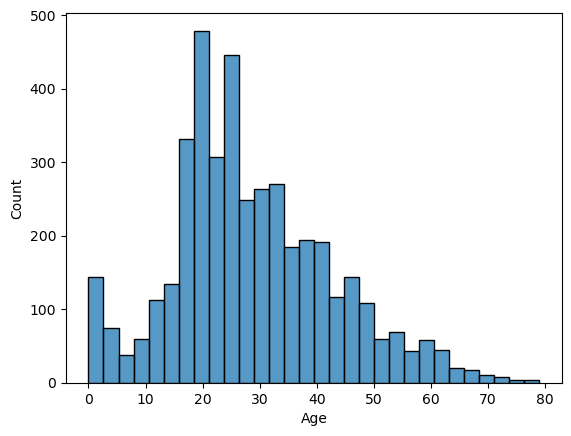

In [259]:
sns.histplot(df['Age'], bins=30)

In [260]:
# mean_age = df['Age'].mean()
# std_age = df['Age'].std()
# is_null = df['Age'].isnull().sum()
# random_sample = np.random.uniform(mean_age - std_age, mean_age + std_age, size=is_null)
# df.loc[df['Age'].isna(), 'Age'] = random_sample

In [261]:
for df in dfs:
    # df['Destination'].fillna(df['Destination'].mode()[0], inplace=True)
    df['VIP'].fillna(df['VIP'].mode()[0], inplace=True)
    df['VIP'] = df['VIP'].astype(int)

In [262]:
for df in dfs:
    df['Name'].fillna('Unknown Unknown', inplace=True)
    df['PassengerId'] = df['PassengerId'].astype(str)
    df.drop(columns='total_spend', inplace=True)
    df.drop(columns='any_spend', inplace=True)

In [263]:
# inefficient code, takes too much time to run 
# df['group_size'] = df['group_id'].map(lambda x: df['group_id'].value_counts()[x])
# df['group_size'] = df['group_size'].astype(int)

In [264]:
for df in dfs:
    group_size = df['group_id'].value_counts().to_dict()
    df['group_size'] = df['group_id'].apply(lambda x: group_size[x])

In [265]:
quant_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'group_size']
quant_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer(n_neighbors=7))
])

In [266]:
for df in dfs:
    df[quant_features] = quant_pipeline.fit_transform(df[quant_features])

In [267]:
cat_features = train_data.select_dtypes(include='category').columns.to_list()
cat_features

['HomePlanet', 'Destination', 'cabin_deck']

In [268]:
train_data = pd.concat([train_data, pd.get_dummies(train_data[cat_features], drop_first=True)], axis=1)
train_data.drop(columns=cat_features, inplace=True)

In [269]:
test_data = pd.concat([test_data, pd.get_dummies(test_data[cat_features], drop_first=True)], axis=1)
test_data.drop(columns=cat_features, inplace=True)

In [270]:
# df.columns
# summary(train_data)
# summary(test_data)

In [271]:
x_train = train_data.drop(['Name', 'PassengerId', 'Transported'], axis=1)
y_train = train_data['Transported']
display(x_train.shape)
display(y_train.shape)

(8693, 23)

(8693,)

In [272]:
x_test = test_data.drop(['Name', 'PassengerId'], axis=1)

In [273]:
# x_train, y_train = df.drop('Transported', axis = 1), df['Transported']
# xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators =10, seed = 123)
# xg_cl.fit(x_train, y_train)